In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

a1, c1 = 2, 3  # для f1(x1,x2) := 2-(x1−6)^2 + 3-(x2−6)^2
a2, c2 = 3, 1   # для f2(x1,x2) := 3-(x1+4)^2 + (x2+6)^2
a3, c3 = 1, 2   # для f3(x1,x2) := (x1+7)^2 + 2-(x2−8)^2

b1, d1 = 6, 6   # для f1
b2, d2 = -4, -6 # для f2
b3, d3 = -7, 8  # для f3

def f1(x):
    return a1 * (x[0] - b1)**2 + c1 * (x[1] - d1)**2

def f2(x):
    return a2 * (x[0] - b2)**2 + c2 * (x[1] - d2)**2

def f3(x):
    return a3 * (x[0] - b3)**2 + c3 * (x[1] - d3)**2

In [ ]:
# 1. Метод аддитивной свертки
def additive_convolution(weights, x0=(0, 0)):
    def F(x):
        return weights[0]*f1(x) + weights[1]*f2(x) + weights[2]*f3(x)
    res = minimize(F, x0, method='BFGS')
    return res.x

weights = [0.33, 0.33, 0.33]
point = additive_convolution(weights)
print("Аддитивная свертка:", point)

# Генерация множества Парето
pareto_additive = []
for alpha in np.linspace(0, 1, 10):
    weights = [alpha, (1-alpha)/2, (1-alpha)/2]
    point = additive_convolution(weights)
    pareto_additive.append(point)
pareto_additive = np.array(pareto_additive)

Аддитивная свертка (как в методичке): [-1.16666668  4.66666707]


In [ ]:
# 2. Дискриминационный метод
def discrimination_method(constraints, x0=(0, 0)):
    def F(x):
        return f1(x) + f2(x) + f3(x)
    
    cons = (
        {'type': 'ineq', 'fun': lambda x: constraints[0] - f1(x)},
        {'type': 'ineq', 'fun': lambda x: constraints[1] - f2(x)},
        {'type': 'ineq', 'fun': lambda x: constraints[2] - f3(x)},
    )
    
    res = minimize(F, x0, method='SLSQP', constraints=cons)
    return res.x

constraints = [200, 62, 180]
point = discrimination_method(constraints)
print("Дискриминационный метод (как в методичке):", point)

# Генерация множества Парето
pareto_discrimination = []
for c in np.linspace(50, 200, 10):
    point = discrimination_method([c, c, c])
    pareto_discrimination.append(point)
pareto_discrimination = np.array(pareto_discrimination)

Дискриминационный метод (как в методичке): [-1.8006915   0.89123549]


In [ ]:
# 3. Метод последовательных уступок (стр. 5)
def successive_concessions(delta_f1=10, delta_f2=100, x0=(0, 0)):
    # Первый этап: минимизация f1
    res1 = minimize(f1, x0, method='BFGS')
    x_opt = res1.x
    f1_opt = f1(x_opt)
    
    # Второй этап: минимизация f2 с уступкой по f1
    cons_f2 = {'type': 'ineq', 'fun': lambda x: delta_f1 - (f1(x) - f1_opt)}
    res2 = minimize(f2, x0, method='SLSQP', constraints=cons_f2)
    x_opt = res2.x
    f2_opt = f2(x_opt)
    
    # Третий этап: минимизация f3 с уступками по f1 и f2
    cons_f3 = (
        {'type': 'ineq', 'fun': lambda x: delta_f1 - (f1(x) - f1_opt)},
        {'type': 'ineq', 'fun': lambda x: delta_f2 - (f2(x) - f2_opt)},
    )
    res3 = minimize(f3, x0, method='SLSQP', constraints=cons_f3)
    return res3.x

point = successive_concessions(delta_f1=10, delta_f2=100)
print("Последовательные уступки (как в методичке):", point)

# Генерация множества Парето
pareto_successive = []
for delta in np.linspace(5, 50, 10):
    point = successive_concessions(delta_f1=delta, delta_f2=delta*10)
    pareto_successive.append(point)
pareto_successive = np.array(pareto_successive)

Последовательные уступки (как в методичке): [3.82467025 6.42264293]


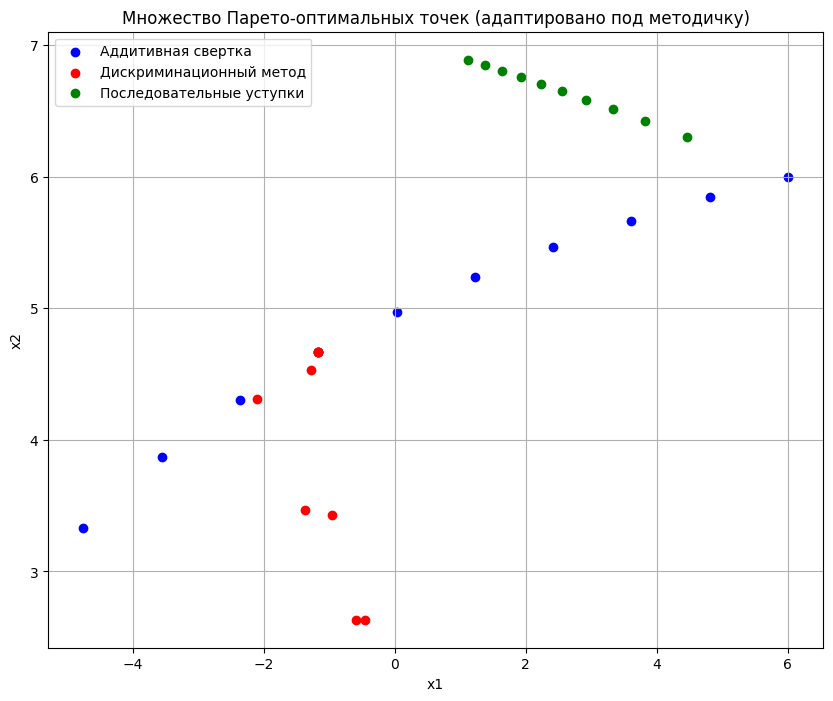

In [15]:
# Визуализация
plt.figure(figsize=(10, 8))
plt.scatter(pareto_additive[:, 0], pareto_additive[:, 1], color='blue', label='Аддитивная свертка')
plt.scatter(pareto_discrimination[:, 0], pareto_discrimination[:, 1], color='red', label='Дискриминационный метод')
plt.scatter(pareto_successive[:, 0], pareto_successive[:, 1], color='green', label='Последовательные уступки')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Множество Парето-оптимальных точек (адаптировано под методичку)')
plt.legend()
plt.grid(True)
plt.show()